# Dexamethosone: SI Figure 11

In [1]:
# A few magic commands...
%load_ext autoreload
%autoreload 2
%matplotlib widget

## Defining Paths

In [2]:
from pathlib import Path

root = Path("../../")
molecule = "dexamethasone"
data_dir = root / "data" / molecule / "1"
output_dir = root / "code" / molecule / "output"

output_dir.mkdir(exist_ok=True, parents=True)

## Loading and Pre-processing the 2DJ Data

In [9]:
import nmrespy as ne

estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_dir)
    estimator.phase_data(p0=-2.152, p1=-6.152, pivot=3294)
    estimator.baseline_correction()
    estimator.to_pickle(estimator_path)

## Running the Estimation Routine

Two regions had initial model orders hard-coded. For the 4.25 - 3.97 ppm region, the fit is imporoved a model order greater than the one determined by the MDL is provided. Conversely, for the 1 - 0.65 ppm region, the MDL predicts a model order which is excessively large, with many low-intensity singals featuring in the final result. A comparison can be made if the lines

    initial_guesses[4] = 22
    initial_guesses[12] = 3

are commented out below.

In [4]:
import numpy as np

np.random.seed(0)

rerun_estimation = False
try:
    if rerun_estimation:
        raise ValueError("Re-running estimation.")
    estimator.get_results()
except ValueError:
    regions = (
        (7.45, 7.15), (6.40, 5.90), (5.50, 4.80),
        (4.80, 4.30), (4.25, 3.97), (3.00, 2.87),
        (2.68, 2.565), (2.413, 2.26), (2.20, 2.03),
        (1.85, 1.70), (1.70, 1.25), (1.14, 1.00),
        (1.00, 0.65),
    )
    estimate_kwargs = dict(
        noise_region=(7.9, 7.8),
        region_unit="ppm",
        max_iterations=200,
        check_neg_amps_every=25,
    )
    initial_guesses = len(regions) * [None]
    initial_guesses[4] = 22
    initial_guesses[12] = 3
    for region, initial_guess in zip(regions, initial_guesses):
        estimator.estimate(
            region=region,
            initial_guess=initial_guess,
            **estimate_kwargs,
        )
        estimator.to_pickle(estimator_path, force_overwrite=True)

┌───────────────────────────────────────┐
│ESTIMATING REGION: 7.45 - 7.15 ppm (F2)│
└───────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 8
--> Pencil parameters: 32, 56
--> Enhanced Block Hankel matrix constructed:
	Size: 1792 x 1848
	Memory: 50.5312MiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 3 secs, 295 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 1.19593      │ 5.44011      │ 1   

## Plotting the Result

Due to the large dynamic range of spectral peaks in this dataset, I have included a hack (between `>>>` and `<<<` in the cell below) to reposition the lines in the plot, since the complex multiplet structures are more interesting than intense singlets/doublets!

The default multiplet threshold is being used for this dataset, which is printed below.

In [27]:
import copy
import matplotlib.pyplot as plt

print("Using default multiplet threshold: {:.3f} Hz".format(estimator.default_multiplet_thold))

default_plot_kawrgs = dict(
    region_unit="ppm",
    xaxis_ticks=[
        (1, [6.3, 6.2, 6.1, 6.0]),
        (2, [5.4 - 0.1 * x for x in range(11)]),
        (3, [4.2, 4.1, 4.0]),
        (4, [2.9]),
        (5, [2.6]),
        (7, [2.1]),
    ],
    multiplet_lw=0.8,
    marker_size=15.0,
    figsize=(20.0, 6.0),
    axes_left=0.05,
    axes_right=0.95,
    axes_bottom=0.1,
    axes_top=0.98,
    contour_base=1.8e3,
    contour_factor=2.0,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
    lb=2.5,
    ratio_1d_2d=(3.0, 1.0),
    clip_mp=8.0e4,
    clip_1d=1.7e5,
    clip_cupid=3.5e5,
)

def plot_result(estimator, **kwargs):
    plot_kwargs = copy.deepcopy(default_plot_kawrgs)
    for key, value in kwargs.items():
        plot_kwargs[key] = value
    fig, axs = estimator.plot_result(**plot_kwargs)
    return fig, axs

colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[:4]
colors.append("#808080")

def make_colors(indices):
    return [colors[i] for i in indices]

Using default multiplet threshold: 1.791 Hz


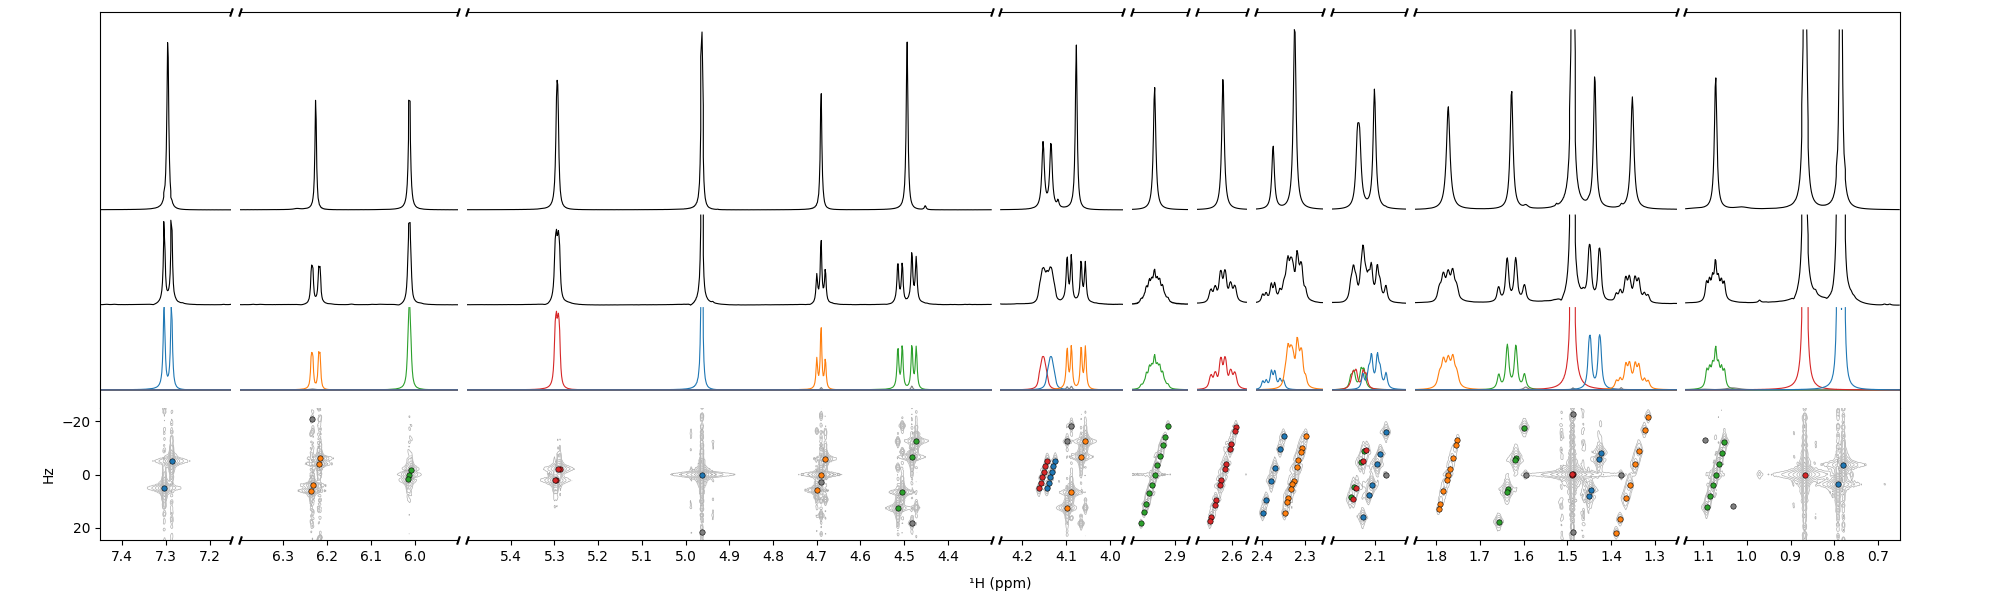

In [28]:
mp_indices = [0, 4, 1, 2, 3, 0, 4, 1, 4, 2, 4, 3, 0, 4, 1, 2, 3, 0, 1, 2, 3, 0, 4, 1, 2, 4, 4, 3, 4, 0, 4, 1, 4, 2, 4, 3, 0]
multiplet_colors = make_colors(mp_indices)
plot_result(estimator, multiplet_colors=multiplet_colors);

## Removing Spurious Signals

There are a few spurious signals in the result, denoted in gray in the abve plot. Some of these can be remove automatically:

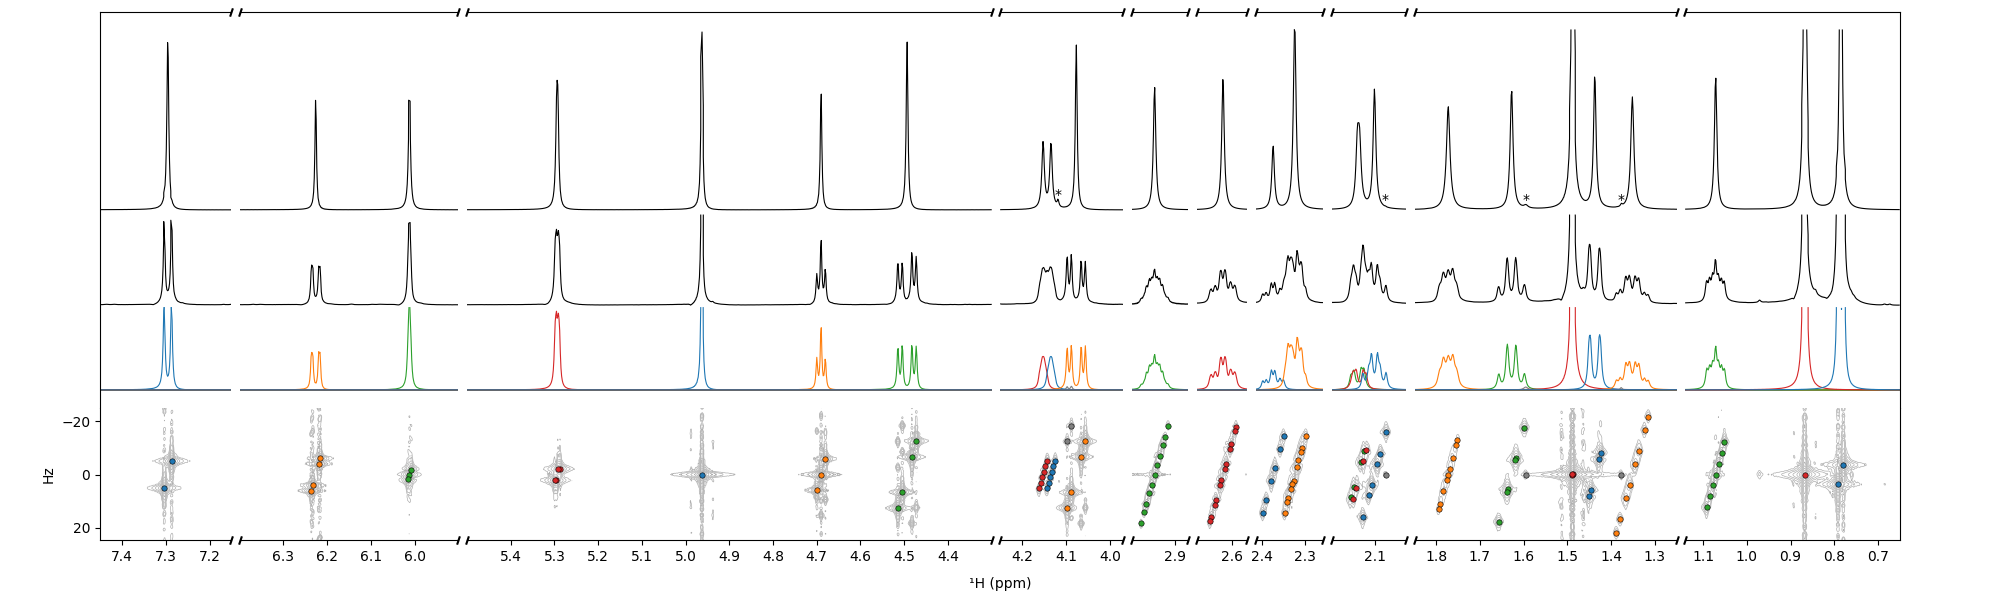

In [32]:
estimator.predict_multiplets(rm_spurious=True)
mp_indices = [0, 1, 2, 3, 0, 1, 2, 3, 0, 4, 1, 2, 3, 0, 1, 2, 3, 0, 4, 1, 2, 4, 3, 0, 4, 1, 2, 3, 0]
multiplet_colors = make_colors(mp_indices)
_, axs = plot_result(estimator, multiplet_colors=multiplet_colors)

# Marking contributions from gray signals in the CUPID spectrum
for ax_idx, x, y in zip(
    [3, 7, 8, 8],
    [4.119, 2.078, 1.594, 1.378],
    [1.9e5, 1.85e5, 1.85e5, 1.85e5],
):
    axs[0, ax_idx].text(x, y, "*", ha="center", va="center")

The gray signals which remain are as follows:

* 4.1 ppm: Two signals which correspond to strong coupling artifacts.
* 2.1 ppm: A very weak signal, which corresponds to a weak peak in the 2DJ spectrum. Likely a ¹ ³C satellite.
* 1.6 ppm & 1.4 ppm: Two weak signals either side of a very intense singlet at ~1.5 ppm. These are likely ¹ ³C satellites too, given that they are equidistant from the singlet.

Their contributions to the final CUPID spectrum are marked with asterisks in the above plot.